In [280]:
import pandas as pd
import matplotlib.pyplot as plt

from kp import kp_indices
from goes import goes16_magnetometer
from storms import geomagnetic_storm_data

## Find Nominal Kp Values

In [253]:
kp = kp_indices()
max_kp_day = kp.groupby(['year', 'month', 'day']).max()['Kp'].reset_index()
no_geo_activity = max_kp_day[max_kp_day.Kp <= 1]

In [254]:
no_activity_may = no_geo_activity[(no_geo_activity.month == 5) & (no_geo_activity.year >= 2018)]

In [255]:
no_activity_may

,year,month,day,Kp
31532,2018,5,1,1.000
31550,2018,5,19,1.000
31551,2018,5,20,1.000
31552,2018,5,21,1.000
31904,2019,5,8,1.000
32271,2020,5,9,0.667
32276,2020,5,14,0.333
32277,2020,5,15,1.000
32279,2020,5,17,1.000
32282,2020,5,20,1.000


In [256]:
no_activity_oct = no_geo_activity[(no_geo_activity.month == 10) & (no_geo_activity.year >= 2018)]
no_activity_oct

,year,month,day,Kp
31702,2018,10,18,0.333
31703,2018,10,19,0.667
31704,2018,10,20,0.333
31707,2018,10,23,1.000
31713,2018,10,29,0.333
32062,2019,10,13,0.667
32072,2019,10,23,0.667
32423,2020,10,8,0.667
32424,2020,10,9,0.333
32425,2020,10,10,0.667


In [125]:
def mean_mags(dts: list[pd.Timestamp]) -> pd.DataFrame:
    mag_dfs = []
    for ts in dts:
        mag_df = goes16_magnetometer(ts)
        da = mag_df.sel(coordinate=1).drop_vars('coordinate')
        df = da.to_dataframe()
    
        df['hour'] = df.index.hour
        df['minute'] = df.index.minute
        df = df.reset_index()[['b_epn', 'hour', 'minute']]
        df.set_index(['hour', 'minute'], inplace=True)
        mag_dfs.append(df)
        
    concats = pd.concat(mag_dfs, axis=1)
    return concats.mean(axis=1), concats.std(axis=1)

In [257]:
dts_may = pd.to_datetime(no_activity_may[['year', 'month', 'day']])
dts_oct = pd.to_datetime(no_activity_oct[['year', 'month', 'day']])
mag_zero_may, _ = mean_mags(dts_may)
mag_zero_oct, _ = mean_mags(dts_oct)

In [258]:
mag_zero_may_values = mag_zero_may.reset_index()
mag_zero_may_values.rename(columns={0: 'B'}, inplace=True)
mag_zero_may_values = mag_zero_may_values.B

mag_zero_oct_values = mag_zero_oct.reset_index()
mag_zero_oct_values.rename(columns={0: 'B'}, inplace=True)
mag_zero_oct_values = mag_zero_oct_values.B

In [259]:
mag_zero_may_values

0       89.934021
1       89.965652
2       89.945290
3       89.863792
4       89.837868
          ...    
1435    95.349701
1436    95.271935
1437    95.178741
1438    95.164131
1439    95.130844
Name: B, Length: 1440, dtype: float32

In [260]:
mag_zero_oct_values

0       92.511955
1       92.427368
2       92.360550
3       92.282616
4       92.187408
          ...    
1435    95.858513
1436    95.815842
1437    95.764572
1438    95.659943
1439    95.597549
Name: B, Length: 1440, dtype: float32

<Axes: >

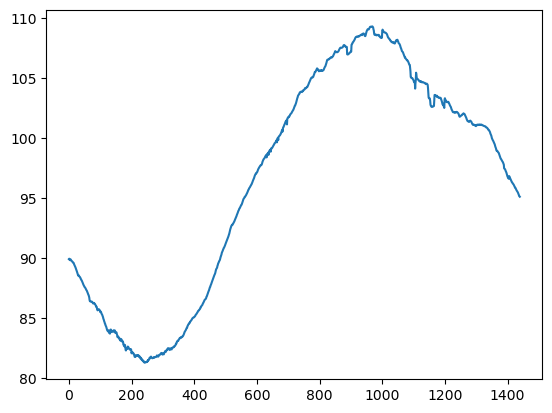

In [261]:
mag_zero_may_values.plot()

<Axes: >

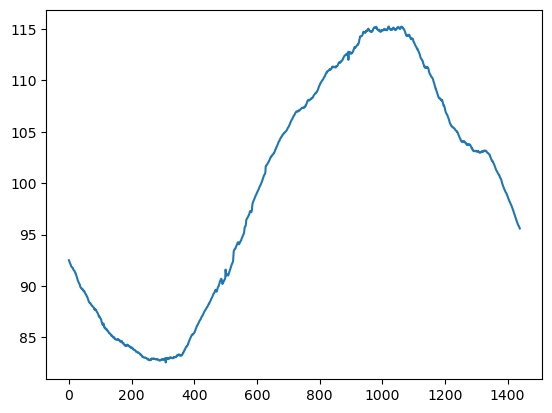

In [262]:
mag_zero_oct_values.plot()

## 10 May Mag/Bz Data and Compare to Nominal

In [273]:
may10_mag = goes16_magnetometer('2024-05-10')
may11_mag = goes16_magnetometer('2024-05-11')
may10_mag = may10_mag.sel(coordinate=1).drop_vars('coordinate').to_dataframe()
may11_mag = may11_mag.sel(coordinate=1).drop_vars('coordinate').to_dataframe()

In [302]:
may10_l1, _= geomagnetic_storm_data('2024-05-10', after_shock=48)
may10_l1 = may10_l1[may10_l1.index >= '2024-05-11T00:00']
may10_l1_bz = may10_l1.bz.reset_index().bz

Text(0.5, 0, 'Minutes since 00 UTC')

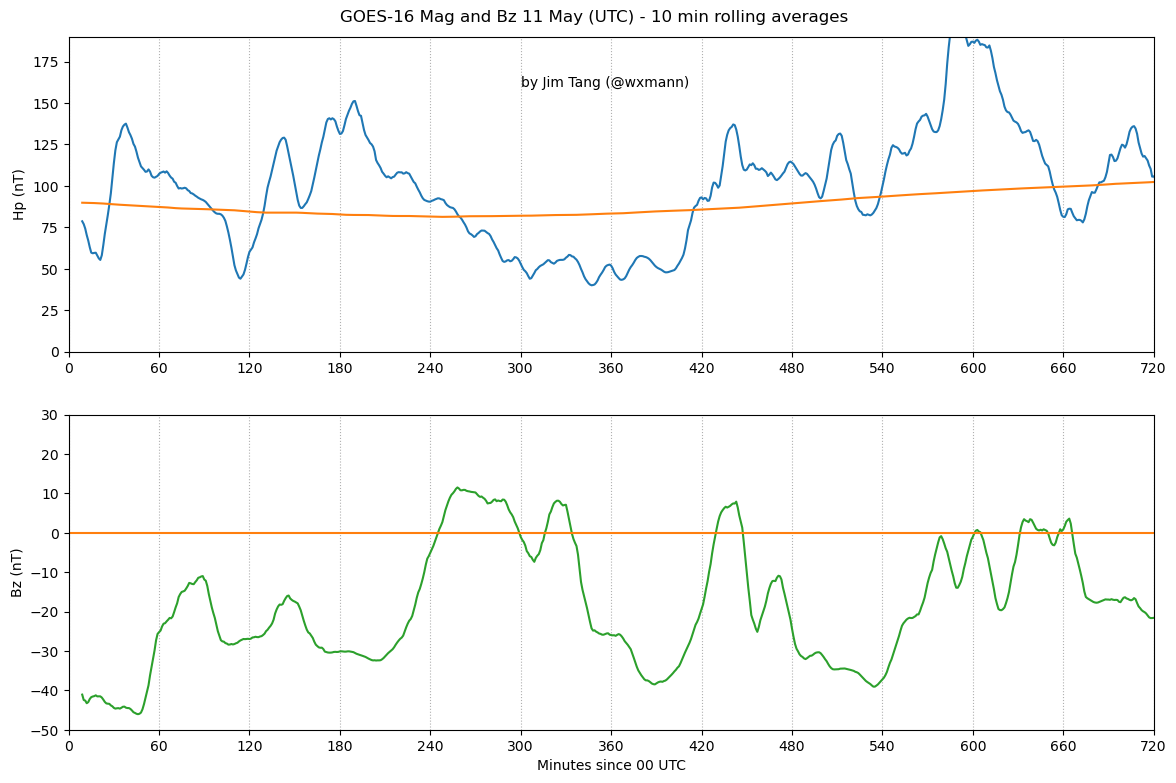

In [372]:
rolling_period = 10
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(14, 9))

may11_mag.reset_index().b_epn.rolling(rolling_period).mean().plot(ax=ax)
mag_zero_may_values.rolling(rolling_period).mean().plot(ax=ax)
may10_l1_bz.rolling(rolling_period).mean().plot(ax=ax2, c='C2')

xlim = [0, 12 * 60]
xmajor = range(0, xlim[1] + 60, 60)
for ax_ in (ax, ax2):
    ax_.set_xlim(xlim)
    ax_.set_xticks(xmajor)
    ax_.grid(axis='x', ls=':')

ax.set_ylim([0, 190])
ax.set_ylabel('Hp (nT)')

ax2.set_ylim([-50, 30])
ax2.axhline(0, c='C1')
ax2.set_ylabel('Bz (nT)')

plt.suptitle('GOES-16 Mag and Bz 11 May (UTC) - 10 min rolling averages', y=0.91)
ax.text(300, 160, 'by Jim Tang (@wxmann)')
ax2.set_xlabel('Minutes since 00 UTC')

## 10 Oct Mag/Bz Data and Compare to Nominal

In [317]:
oct10_mag = goes16_magnetometer('2024-10-10')
oct11_mag = goes16_magnetometer('2024-10-11')
oct10_mag = oct10_mag.sel(coordinate=1).drop_vars('coordinate').to_dataframe()
oct11_mag = oct11_mag.sel(coordinate=1).drop_vars('coordinate').to_dataframe()
# oct10_mag

In [316]:
oct10_l1, _= geomagnetic_storm_data('2024-10-10', after_shock=48)
oct10_l1 = oct10_l1[oct10_l1.index >= '2024-10-11T00:00']
oct10_l1_bz = oct10_l1.bz.reset_index().bz

/Users/jimtang/Dev/historical-solar-wind/storms.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Rate_of_Change"] = df[column].pct_change() * 100  # Convert to percentage


Text(0.5, 0, 'Minutes since 00 UTC')

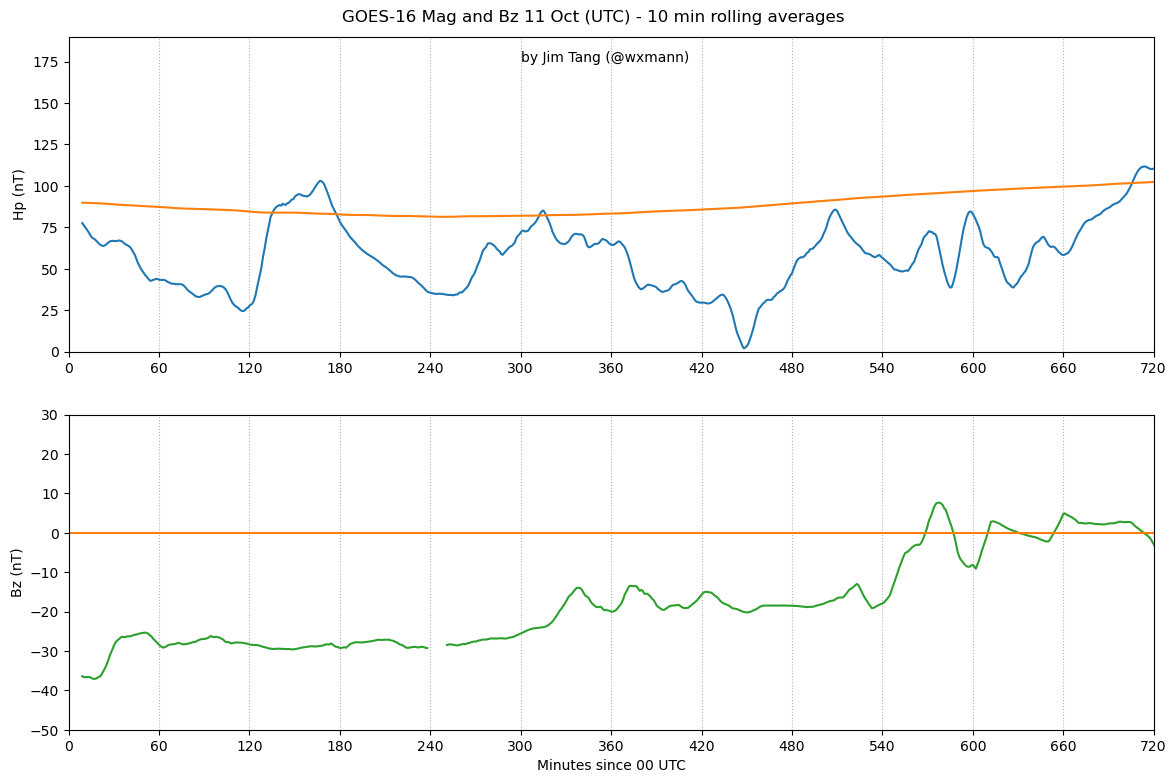

In [371]:
rolling_period = 10
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(14, 9))

oct11_mag.reset_index().b_epn.rolling(rolling_period).mean().plot(ax=ax)
mag_zero_may_values.rolling(rolling_period).mean().plot(ax=ax)
oct10_l1_bz.rolling(rolling_period).mean().plot(ax=ax2, c='C2')

xlim = [0, 12 * 60]
xmajor = range(0, xlim[1] + 60, 60)
for ax_ in (ax, ax2):
    ax_.set_xlim(xlim)
    ax_.set_xticks(xmajor)
    ax_.grid(axis='x', ls=':')

ax.set_ylim([0, 190])
ax.set_ylabel('Hp (nT)')

ax2.set_ylim([-50, 30])
ax2.axhline(0, c='C1')
ax2.set_ylabel('Bz (nT)')

plt.suptitle('GOES-16 Mag and Bz 11 Oct (UTC) - 10 min rolling averages', y=0.91)
ax.text(300, 175, 'by Jim Tang (@wxmann)')
ax2.set_xlabel('Minutes since 00 UTC')